# 2-6. KODEX국고채3년 & 10년 월별 절대모멘텀 비교

In [1]:
import pandas as pd
import numpy as np

### 함수

In [2]:
def 월별수익(data):
    result = data/data.shift(1)
    return result

def 절대모멘텀(data,month):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = np.where(data/data.shift(month)>1,1,0)
    return result

def CAGR(data):
    y = data.index.year.unique()
    result = (data[-1]/data[0])**(1/len(y))-1
    return np.round(result,4)

def MDD(data):
    # We are going to use a trailing 252 trading day window
    window = len(data)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = data.rolling(window, min_periods=1).max()
    Roll_Max.rename("Roll_Max", inplace=True)
    Drawdown = data/Roll_Max - 1.0
    Drawdown.rename("Drawdown", inplace=True)

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Drawdown = Drawdown.rolling(window, min_periods=1).min()
    Max_Drawdown.rename("Max_Drawdown", inplace=True)
    
    return np.round(Drawdown,4), np.round(Max_Drawdown,4)

# Main

### csv 파일 읽어오기

In [3]:
year3 = pd.read_csv("KODEX국고채3년_monthly_data.csv", encoding="utf-8", engine="python")
year10 = pd.read_csv("KOSEF국고채10년_monthly_data.csv", encoding="utf-8", engine="python")

### Index는 datetime 형으로 변환하기

In [4]:
year3.index = pd.to_datetime(year3["Date"])
year10.index = pd.to_datetime(year10["Date"])

year3 = year3["Close"]; year3.rename("year3", inplace=True)
year10 = year10["Close"]; year10.rename("year10", inplace=True)

#KODEX200 re-scale 1
year3 = year3/year3.iloc[0]
year10 = year10/year10.iloc[0]

### 년도 구분하여 데이터 만들기

In [5]:
#year3 = year3[:"2015"]
#year10 = year10[:"2015"]

### 개월수별 절대모멘텀 값 구하기, CAGR/MDD 구하기

In [6]:
year3_CAGR = CAGR(year3) # CAGR 구하기
year3_DD,year3_MDD  = MDD(year3)  # MDD 구하기
year3누적월별수익 = 월별수익(year3).cumprod()  #누적수익률 구하기

year10_CAGR = CAGR(year10) # CAGR 구하기
year10_DD,year10_MDD  = MDD(year10)  # MDD 구하기
year10누적월별수익 = 월별수익(year10).cumprod()  #누적수익률 구하기

print ("year3_CAGR CAGR {:.2%} ".format(year3_CAGR))
print ("year3_CAGR MDD {:.2%}".format(year3_MDD.min()))
print ("year3_CAGR 누적월별수익 {:.2%}".format(year3누적월별수익[-1]))
print ("")

print ("year10_CAGR CAGR {:.2%} ".format(year10_CAGR))
print ("year10_CAGR MDD {:.2%}".format(year10_MDD.min()))
print ("year10_CAGR 누적월별수익 {:.2%}".format(year10누적월별수익[-1]))

i2name = {1:"개월1",2:"개월2",3:"개월3",4:"개월4",5:"개월5",6:"개월6",
         7:"개월7",8:"개월8",9:"개월9",10:"개월10",11:"개월11",12:"개월12"}

결과year3 = year3.copy()
결과year10 = year10.copy()

year3_CAGR CAGR 3.04% 
year3_CAGR MDD -1.25%
year3_CAGR 누적월별수익 134.89%

year10_CAGR CAGR 3.69% 
year10_CAGR MDD -8.31%
year10_CAGR 누적월별수익 138.51%


#### 절대모멘텀  3월이 '0'이상 이라면 4월 월수익을 사용한다. ? 3월 월수익은 2월달 투입금액의 수익이다.

In [7]:
year3월수익 = 월별수익(year3)
year3result = pd.Series([np.round(year3_CAGR*100,2),np.round(year3_MDD.min()*100,2),np.round(year3누적월별수익.dropna()[-1]*100,2)],index=["절대CAGR","절대MDD","누적월별수익"], name="year3")
자본 = 1

for i in range(1,13):
    # 절대모멘텀 결과값을 오른쪽을 shift한다. 이렇게 해야 투입 달, 다음달 수익률 곱으로 계산된다.
    # 시계열 입력/결과 출력의 date index를 맞추게 된다.
    모멘텀점수 = pd.Series(절대모멘텀(year3,i)).shift(1)
    누적월별수익 = year3월수익[모멘텀점수.values == 1].cumprod()  #블린 인덱스후 월별수익은 누적곱으로 구한다.
    절대 = 누적월별수익 * 자본; 절대.rename(i2name[i], inplace=True)
    결과year3 = pd.concat([결과year3, 절대],axis=1)
    절대CAGR = CAGR(절대.dropna())
    절대DD, 절대MDD = MDD(절대)
    i2name[i] = pd.Series([np.round(절대CAGR*100,2), np.round(절대MDD.min()*100,2), np.round(누적월별수익.dropna()[-1]*100,2)], index=["절대CAGR","절대MDD","누적월별수익"], name=i)
    year3result = pd.concat([year3result,i2name[i]],axis=1)

In [8]:
year10월수익 = 월별수익(year10)
year10result = pd.Series([np.round(year10_CAGR*100,2),np.round(year10_MDD.min()*100,2),np.round(year10누적월별수익.dropna()[-1]*100,2)],index=["절대CAGR","절대MDD","누적월별수익"], name="year10")
자본 = 1

i2name = {1:"개월1",2:"개월2",3:"개월3",4:"개월4",5:"개월5",6:"개월6",
         7:"개월7",8:"개월8",9:"개월9",10:"개월10",11:"개월11",12:"개월12"}

for i in range(1,13):
    # 절대모멘텀 결과값을 오른쪽을 shift한다. 이렇게 해야 투입 달, 다음달 수익률 곱으로 계산된다.
    # 시계열 입력/결과 출력의 date index를 맞추게 된다.
    모멘텀점수 = pd.Series(절대모멘텀(year10,i)).shift(1)
    누적월별수익 = year10월수익[모멘텀점수.values == 1].cumprod()  #블린 인덱스후 월별수익은 누적곱으로 구한다.
    절대 = 누적월별수익 * 자본; 절대.rename(i2name[i], inplace=True)
    결과year10 = pd.concat([결과year10, 절대],axis=1)
    절대CAGR = CAGR(절대.dropna())
    절대DD, 절대MDD = MDD(절대)
    i2name[i] = pd.Series([np.round(절대CAGR*100,2), np.round(절대MDD.min()*100,2), np.round(누적월별수익.dropna()[-1]*100,2)], index=["절대CAGR","절대MDD","누적월별수익"], name=i)
    year10result = pd.concat([year10result,i2name[i]],axis=1)

In [9]:
year3result

,year3,1,2,3,4,5,6,7,8,9,10,11,12
절대CAGR,3.04,2.38,2.45,2.62,2.59,2.48,2.40,2.26,2.26,2.3,2.30,2.71,2.68
절대MDD,-1.25,-0.71,-0.84,-0.87,-0.99,-1.70,-1.76,-2.02,-1.84,-1.3,-1.48,-1.25,-1.25
누적월별수익,134.89,127.72,128.62,129.74,128.90,128.45,128.25,126.20,125.28,126.0,125.22,126.40,127.75


In [10]:
year10result

,year10,1,2,3,4,5,6,7,8,9,10,11,12
절대CAGR,3.69,3.15,3.82,4.07,3.98,3.50,3.51,3.55,2.98,2.53,2.99,2.15,1.98
절대MDD,-8.31,-5.44,-3.15,-3.15,-5.50,-6.74,-6.39,-6.43,-5.66,-6.44,-5.63,-5.66,-5.63
누적월별수익,138.51,132.75,135.50,137.60,135.90,133.15,133.40,133.06,130.74,123.37,123.38,119.05,116.84


### 국고채 3년, 10년 수익그래프

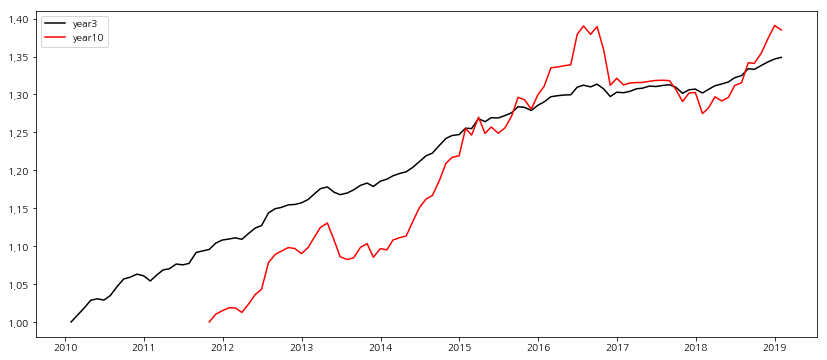

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(year3,color="Black", label="year3");
ax.plot(year10,color="Red", label="year10");
ax.legend();

### 그래프 그리기

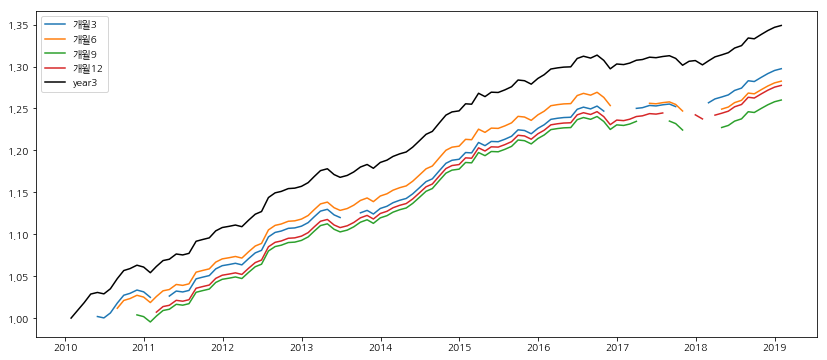

In [12]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
#ax.plot(결과["1개월"]);
ax.plot(결과year3["개월3"]);
ax.plot(결과year3["개월6"]);
ax.plot(결과year3["개월9"]);
ax.plot(결과year3["개월12"]);
ax.plot(year3,color="Black", label="year3");
ax.legend();

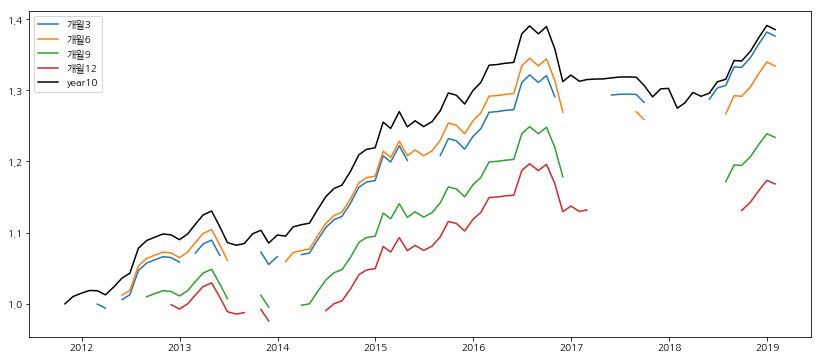

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
#ax.plot(결과["1개월"]);
ax.plot(결과year10["개월3"]);
ax.plot(결과year10["개월6"]);
ax.plot(결과year10["개월9"]);
ax.plot(결과year10["개월12"]);
ax.plot(year10,color="Black", label="year10");
ax.legend();